## Load the dataset from Kaggle

In [1]:
pip install kaggle

In [2]:
!kaggle datasets download -d tessaagitha/skinsightapp

Dataset URL: https://www.kaggle.com/datasets/tessaagitha/skinsightapp
License(s): unknown
 73% 18.0M/24.5M [00:00<00:00, 62.7MB/s]
100% 24.5M/24.5M [00:00<00:00, 82.4MB/s]


In [3]:
import zipfile
import os

# Buat direktori untuk dataset
os.makedirs('skinsightapp', exist_ok=True)

# Ekstrak file zip ke direktori yang sudah dibuat
with zipfile.ZipFile('skinsightapp.zip', 'r') as zip_ref:
    zip_ref.extractall('skinsightapp')

In [4]:
DATASET_PATH = '/content/skinsightapp/dataset_capstone'

In [5]:
classes = ['Acne', 'Blackhead', 'Redness']

## Import library

In [6]:
import random
import shutil
import cv2
import os
from PIL import Image
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from matplotlib.image import imread
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

## Pre-processing

In [7]:
def check_dataset(PATH, classes):
  '''
  Print number of images per class
  and total of images
  '''
  num_files = 0
  for cls in classes:
    length = len(os.listdir(os.path.join(PATH, cls)))
    print(f"Number of images for {cls}: {length}")
    num_files += length
  print("="*15)
  print("Number of images total:", num_files)

In [8]:
check_dataset(DATASET_PATH, classes)

Number of images for Acne: 215
Number of images for Blackhead: 215
Number of images for Redness: 215
Number of images total: 645


data is balanced

In [9]:
def show_images_by_path(DATASET_PATH, cls):
  '''
  Show 6 images of the given class
  '''
  DIR = os.path.join(DATASET_PATH, cls)
  image_got = 0
  plt.figure(figsize=(36,6))
  for root, dirs, files in os.walk(DIR):
    for file in files:
      if image_got == 6:
        break
      image_got += 1
      img = mpimg.imread(os.path.join(root, file))
      plt.subplot(1, 6, image_got)
      plt.imshow(img)
  plt.show

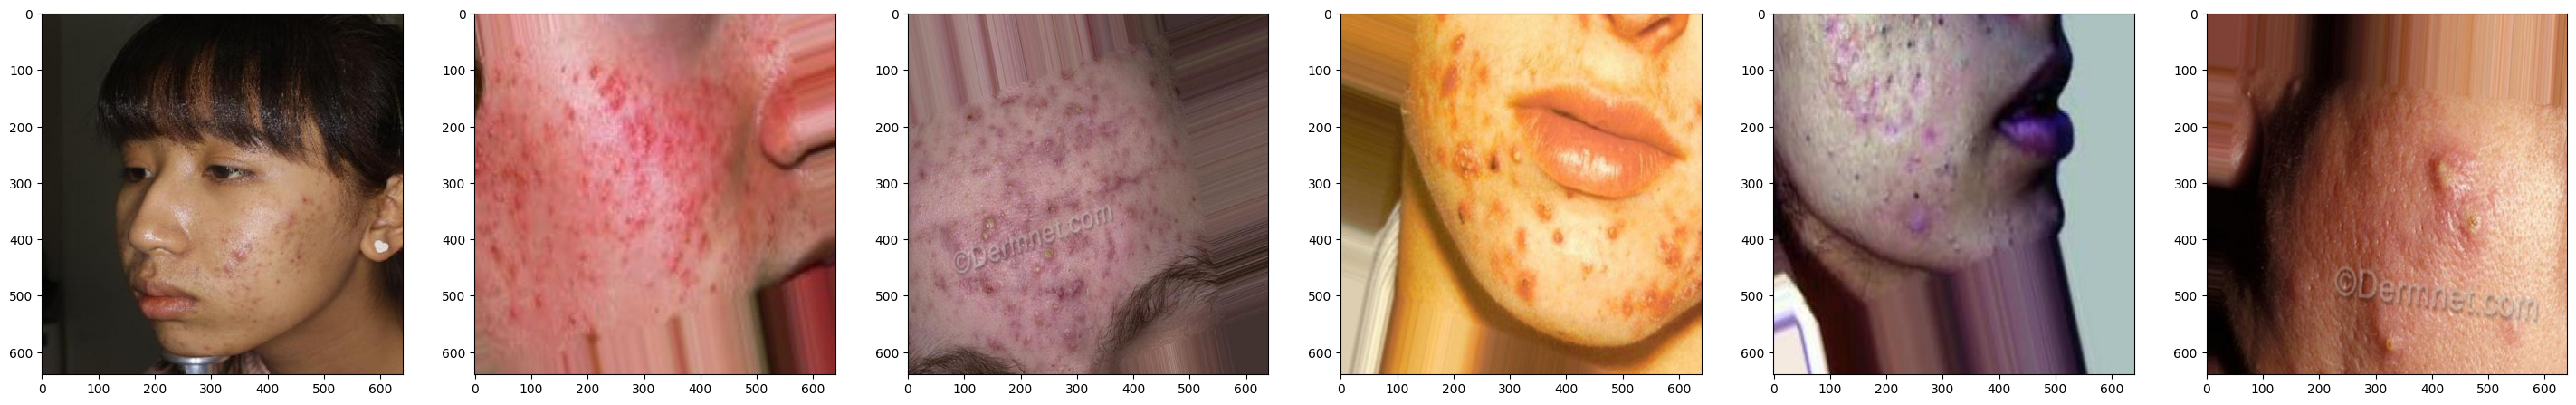

In [10]:
show_images_by_path(DATASET_PATH, 'Acne')

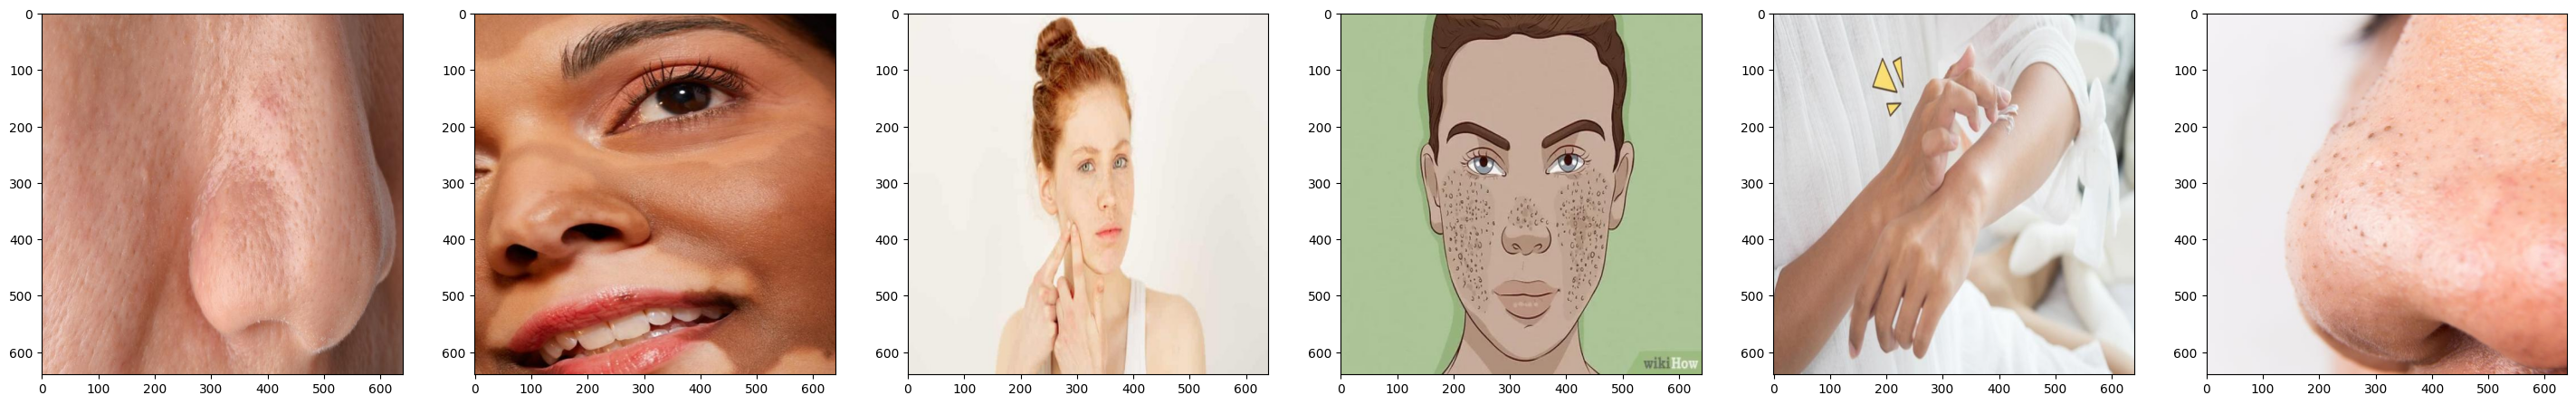

In [11]:
show_images_by_path(DATASET_PATH, 'Blackhead')

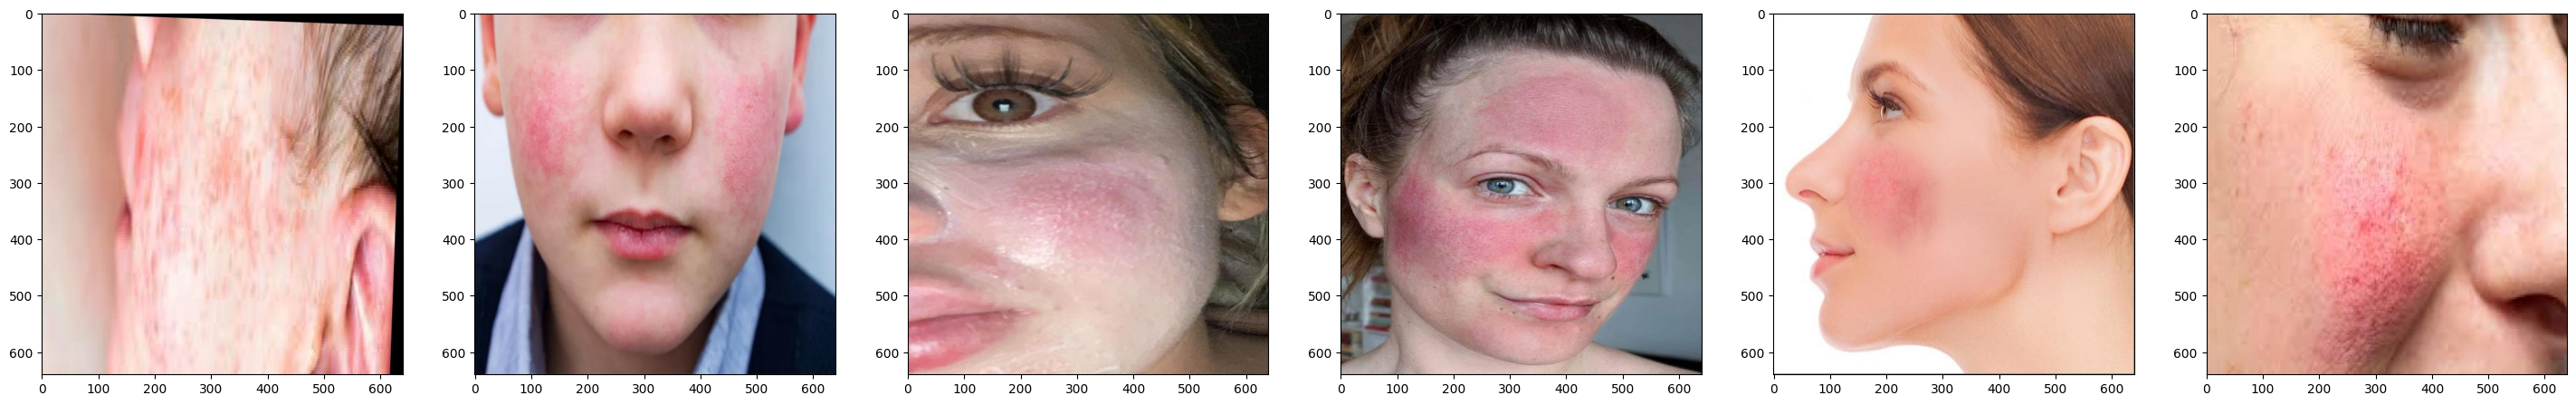

In [12]:
show_images_by_path(DATASET_PATH, 'Redness')

## Prepare Dataset

In [13]:
def compare_two_images(image1, image2):
  fig = plt.figure(figsize=(10, 7))
  fig.add_subplot(1, 2, 1)
  plt.imshow(image1)
  fig.add_subplot(1, 2, 2)
  plt.imshow(image2)
  plt.show()

In [14]:
def show_images(images, num):
  image_got = 0
  plt.figure(figsize=(num*6,num))
  for idx, img in enumerate(images):
    plt.subplot(1, num, idx+1)
    plt.imshow(img)
  plt.show

In [15]:
import os
import cv2
import numpy as np
import random

class ImageAugmentor:
  def __init__(self, image_folder):
    self.image_folder = image_folder

  def convert_to_RGB(self, image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

  def resize_image(self, image, size=(640, 640)):
    return cv2.resize(image, size)

  def rotate_image(self, image, angle, cvt=False):
    if cvt:
      image = self.convert_to_RGB(image)
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return self.resize_image(rotated_image)

  def shift_image(self, image, shift_x, shift_y, cvt=False):
    if cvt:
      image = self.convert_to_RGB(image)
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    shifted_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    return self.resize_image(shifted_image)

  def zoom_image(self, image, zoom_factor, cvt=False):
    if cvt:
      image = self.convert_to_RGB(image)
    height, width = image.shape[:2]
    zoom_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), 0, zoom_factor)
    zoomed_image = cv2.warpAffine(image, zoom_matrix, (width, height))
    return self.resize_image(zoomed_image)

  def crop_image(self, image, x, y, width, height, cvt=False):
    if cvt:
      image = self.convert_to_RGB(image)
    cropped_image = image[y:y+height, x:x+width]
    return self.resize_image(cropped_image)

  def augment_images(self, save_dir=None):
    image_files = os.listdir(self.image_folder)
    augmented_images = []

    for image_file in image_files:
      image_path = os.path.join(self.image_folder, image_file)
      image = self.convert_to_RGB(cv2.imread(image_path))

      # Rotate the image
      rotated_image = self.rotate_image(image, 45)
      augmented_images.append(rotated_image)

      # Shift the image
      shifted_image = self.shift_image(image, 50, 50)
      augmented_images.append(shifted_image)

      # Zoom the image
      zoomed_image = self.zoom_image(image, 1.5)
      augmented_images.append(zoomed_image)

      # Crop the image
      cropped_image = self.crop_image(image, 100, 100, 300, 300)
      augmented_images.append(cropped_image)

      if save_dir:
        # Save the augmented images
        save_path = os.path.join(save_dir, f"augmented_{image_file}")
        cv2.imwrite(save_path, cropped_image)

    return augmented_images

  def augment_images_randomized(self, save_dir=None, cvt=False):
    image_files = os.listdir(self.image_folder)
    augmented_images = []
    real_images = []

    for image_file in image_files:
      image_path = os.path.join(self.image_folder, image_file)
      image = cv2.imread(image_path)
      if cvt:
        image = self.convert_to_RGB(image)

      # Generate random parameters
      angle = random.uniform(-30, 30)
      shift_x = random.randint(-50, 50)
      shift_y = random.randint(-50, 50)
      zoom_factor = random.uniform(0.7, 1.3)
      crop_x = random.randint(0, max(0, image.shape[1] - 300))
      crop_y = random.randint(0, max(0, image.shape[0] - 300))
      crop_width = random.randint(100, min(image.shape[1], 300))
      crop_height = random.randint(100, min(image.shape[0], 300))

      # Rotate the image
      rotated_image = self.rotate_image(image, angle)
      augmented_images.append(rotated_image)
      real_images.append(image)

      # Shift the image
      shifted_image = self.shift_image(image, shift_x, shift_y)
      augmented_images.append(shifted_image)
      real_images.append(image)

      # Zoom the image
      zoomed_image = self.zoom_image(image, zoom_factor)
      augmented_images.append(zoomed_image)
      real_images.append(image)

      # Crop the image
      cropped_image = self.crop_image(image, crop_x, crop_y, crop_width, crop_height)
      augmented_images.append(cropped_image)
      real_images.append(image)

      if save_dir:
        # Save the augmented images
        save_path = os.path.join(save_dir, f"augmented_cropped_{image_file}")
        cv2.imwrite(save_path, cropped_image)

      if save_dir:
        # Save the augmented images
        save_path = os.path.join(save_dir, f"augmented_zoomed_{image_file}")
        cv2.imwrite(save_path, zoomed_image)

    return augmented_images, real_images

In [16]:
augmentor = ImageAugmentor(os.path.join(DATASET_PATH, 'Blackhead'))

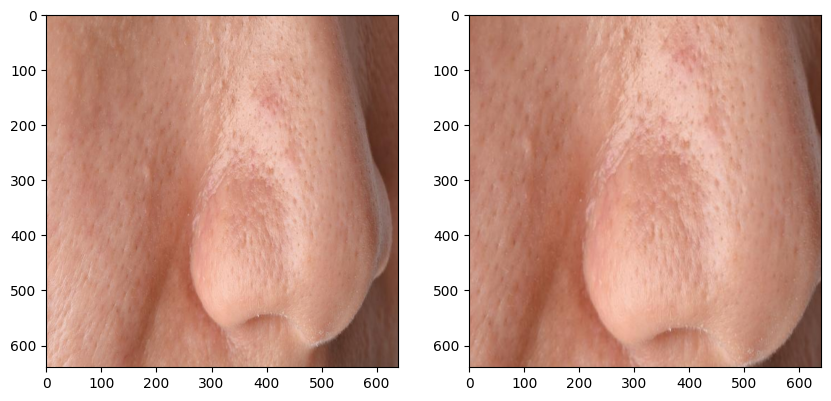

In [17]:
_path = os.path.join(DATASET_PATH + '/Blackhead', os.listdir(DATASET_PATH + '/Blackhead')[0])
img = cv2.imread(_path)
aug_img = augmentor.crop_image(img, 100, 100, 500, 500, True)
compare_two_images(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), aug_img)

In [18]:
aug_images, real_images = augmentor.augment_images_randomized(cvt=True)

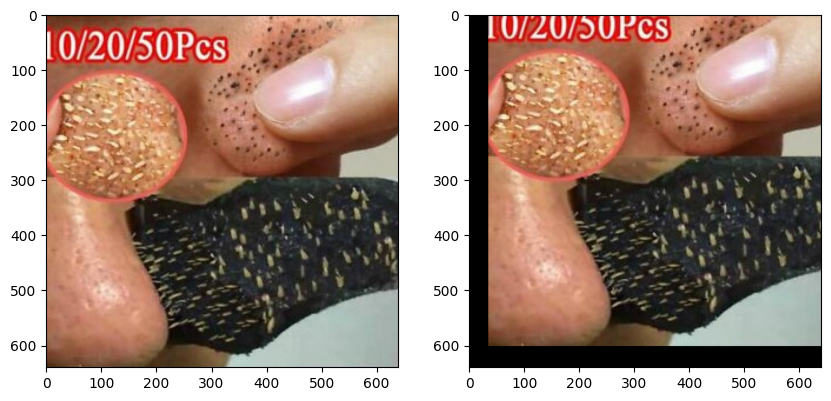

In [19]:
compare_two_images(real_images[101], aug_images[101])

In [20]:
augmented_dir = '/content/dataset'
os.makedirs(augmented_dir, exist_ok=True)

## SPLIT DATASET

In [21]:
def split_data(base_dir, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.2, 0.1)):
    for category in os.listdir(base_dir):
        category_dir = os.path.join(base_dir, category)
        if not os.path.isdir(category_dir):
            continue
        images = os.listdir(category_dir)
        train_images, temp_images = train_test_split(images, test_size=(1 - split_ratio[0]), random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=(split_ratio[2] / (split_ratio[1] + split_ratio[2])), random_state=42)

        for image in train_images:
            os.makedirs(os.path.join(train_dir, category), exist_ok=True)
            shutil.copy(os.path.join(category_dir, image), os.path.join(train_dir, category, image))

        for image in val_images:
            os.makedirs(os.path.join(val_dir, category), exist_ok=True)
            shutil.copy(os.path.join(category_dir, image), os.path.join(val_dir, category, image))

        for image in test_images:
            os.makedirs(os.path.join(test_dir, category), exist_ok=True)
            shutil.copy(os.path.join(category_dir, image), os.path.join(test_dir, category, image))

In [22]:
base_dir = '/content/skinsightapp/dataset_capstone'  # Path ke dataset asli
train_dir = 'split_dataset/train'
val_dir = 'split_dataset/val'
test_dir = 'split_dataset/test'

In [23]:
split_data(base_dir, train_dir, val_dir, test_dir)

In [24]:
def count_files(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            num_files = len(os.listdir(class_dir))
            class_counts[class_name] = num_files
    return class_counts

train_counts = count_files(train_dir)
val_counts = count_files(val_dir)
test_counts = count_files(test_dir)

print("Jumlah data di direktori train:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nJumlah data di direktori val:")
for class_name, count in val_counts.items():
    print(f"{class_name}: {count}")

print("\nJumlah data di direktori test:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")

Jumlah data di direktori train:
Redness: 150
Acne: 150
Blackhead: 150

Jumlah data di direktori val:
Redness: 43
Acne: 43
Blackhead: 43

Jumlah data di direktori test:
Redness: 22
Acne: 22
Blackhead: 22


## Pre-processing and Augmentation

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator untuk preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk training set
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=['Acne', 'Blackhead', 'Redness'],
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (224, 224)
                                                    )

# Generator untuk validation set
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                            classes=['Acne', 'Blackhead', 'Redness'],
                                                            batch_size = 20,
                                                            class_mode = 'categorical',
                                                            target_size = (224, 224)
                                                          )

# Generator untuk test set
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    classes=['Acne', 'Blackhead', 'Redness'],
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (224, 224)
                                                    )

Found 450 images belonging to 3 classes.
Found 129 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


## Models

In [26]:
from tensorflow.keras import backend as K

# Create custome recall, precision, and f1 function
# as model matrics to monitor

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
# Define the image dimensions and number of classes
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3
NUM_CLASSES = 3

In [28]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, Flatten, MaxPooling2D

def custom_model(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), num_classes=3):
    # Load the pre-trained MobileNetV2 model
    pre_trained_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in pre_trained_model.layers:
        layer.trainable = False

    # Custom classification layers on top of the base model
    x = pre_trained_model.output
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=pre_trained_model.input, outputs=predictions)

    return model


In [29]:
model = custom_model()

9406464/9406464 [==============================] - 0s 0us/step


In [30]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

## TRAINING


In [32]:
# Create csvlogger to save model history

from keras.callbacks import CSVLogger
base_dir_train = '/content/skinsightapp'
LOGGER_PATH = f"{base_dir_train}/training/model_checkpoints/best_model5_simple_augmented/training.log"
csv_logger = CSVLogger('LOGGER_PATH', separator=',', append=False)

In [33]:
def earlystop(mode):
  if mode=='accuracy':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min')
  return estop

earlystop = earlystop('accuracy')

CHECKPOINT_PATH = f"{base_dir_train}/training/model_checkpoints/best_model5_simple_augmented/best_model"
checkpoint = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                            save_best_only=True, monitor='val_loss', mode="min")

In [34]:
batch_size = 32
total_train_data = 450
total_val_data = 129
steps_per_epoch = total_train_data // batch_size
validation_steps = total_val_data // batch_size
model_history = model.fit(train_generator,
                          epochs=50,
                          steps_per_epoch=steps_per_epoch,
                          validation_steps=validation_steps,
                          validation_data=validation_generator,
                          shuffle=True,
                          callbacks=[checkpoint, csv_logger])

Epoch 1/50
14/14 [==============================] - 47s 3s/step - loss: 1.2635 - accuracy: 0.4222 - val_loss: 0.7533 - val_accuracy: 0.7000
Epoch 2/50
14/14 [==============================] - 42s 3s/step - loss: 0.7973 - accuracy: 0.6481 - val_loss: 0.5873 - val_accuracy: 0.7625
Epoch 3/50
14/14 [==============================] - 24s 2s/step - loss: 0.6112 - accuracy: 0.7519 - val_loss: 0.6204 - val_accuracy: 0.7375
Epoch 4/50
14/14 [==============================] - 26s 2s/step - loss: 0.4739 - accuracy: 0.8536 - val_loss: 0.6934 - val_accuracy: 0.7125
Epoch 5/50
14/14 [==============================] - 24s 2s/step - loss: 0.4306 - accuracy: 0.8714 - val_loss: 0.5955 - val_accuracy: 0.7875
Epoch 6/50
14/14 [==============================] - 47s 3s/step - loss: 0.3279 - accuracy: 0.8778 - val_loss: 0.4672 - val_accuracy: 0.8000
Epoch 7/50
14/14 [==============================] - 26s 2s/step - loss: 0.4129 - accuracy: 0.8750 - val_loss: 0.7466 - val_accuracy: 0.7625
Epoch 8/50
14/14 [==

## Evaluate Model

In [35]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

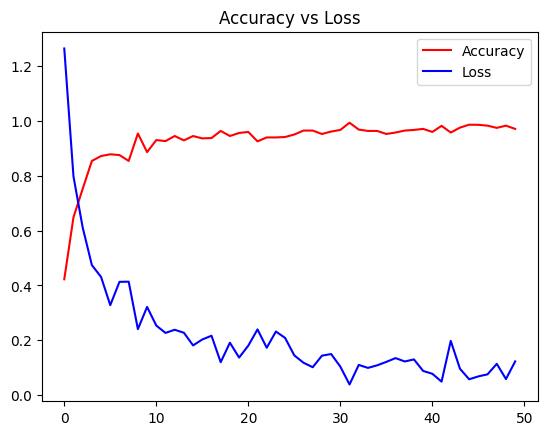

<Figure size 640x480 with 0 Axes>

In [44]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Accuracy')
plt.plot(epochs, loss, 'b', label='Loss')
plt.title('Accuracy vs Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Load Model

In [38]:
import pickle
HISTORY_PATH = f"{base_dir_train}/training/model_checkpoints/best_model5_simple_augmented/history.pkl"
with open(HISTORY_PATH, 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

In [39]:
with open(HISTORY_PATH, "rb") as file_pi:
    history = pickle.load(file_pi)

In [41]:
import tensorflow as tf

# Define or import your custom accuracy function here if needed
def accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(y_true, y_pred)

# Path to your saved model checkpoint
CHECKPOINT_PATH = f"{base_dir_train}/training/model_checkpoints/best_model5_simple_augmented/best_model"

# Load the model with custom objects dictionary
loaded_model = tf.keras.models.load_model(
    CHECKPOINT_PATH,
    custom_objects={'accuracy': acc}
)


In [45]:
import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path=fn
  img=load_img(path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  pred = loaded_model.predict(images, batch_size=32)

  print(pred)

Saving 62c2e5164997e.png to 62c2e5164997e.png
1/1 [==============================] - 1s 1s/step
[[0.00670341 0.99170285 0.00159369]]


In [46]:
import shutil

# Specify the folder to be archived
folder_to_zip = '/content/skinsightapp/split_dataset'

# Specify the name of the output zip file
output_filename = 'split_dataset'

# Create a zip archive
shutil.make_archive(output_filename, 'zip', folder_to_zip)

# Verify the archive
!ls -lh {output_filename}.zip

-rw-r--r-- 1 root root 22 Jun 20 18:05 split_dataset.zip


In [47]:
import shutil

# Specify the folder to be archived
folder_to_zip = '/content/skinsightapp/training'

# Specify the name of the output zip file
output_filename = 'model'

# Create a zip archive
shutil.make_archive(output_filename, 'zip', folder_to_zip)

# Verify the archive
!ls -lh {output_filename}.zip

-rw-r--r-- 1 root root 44M Jun 20 18:06 model.zip
